In [1]:
#pip install pennylane

In [4]:
import pennylane as qml
from pennylane import numpy as np
np.random.seed(0)

import flatnetwork_simple as fns

# REAL S&P 500 DATASET

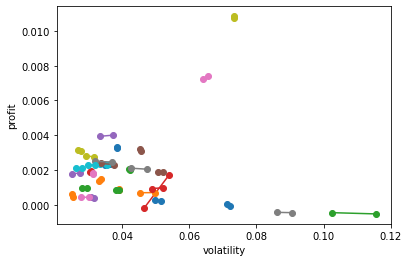

In [5]:
from dataloader_class import *
dl = data_loader('data/covid2020.csv')
dl.split_windows(180)
dl.plot_trajectories()

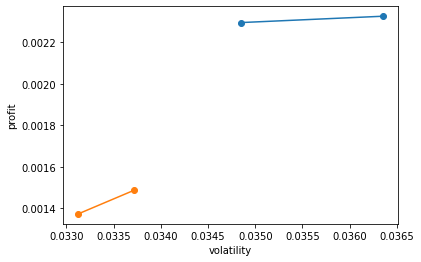

In [6]:
dl.filter_assets(num_assets=2, method='relevant')
dl.plot_trajectories()

In [7]:
mut = dl.return_mut()
sigmat = dl.return_sigmat()
print(mut.shape)

(2, 2)


# DMRG SOLUTION

In [8]:
L = [mut.shape[0],mut.shape[1],2]
d = 2

#Parameters
mu = lambda t,i: mut[t,i]
rho = 5.0

fnet = fns.FlatNetwork(L,d)
fnet.loadParams(mu, rho)
fnet.make_mpos()

S, D = fnet.getHamiltonian()

Max MPO dim:  9


In [9]:
sweepD = [     1,     2,     2,     3,     3,     4,     5,     8,    10]
sweepI = [    10,    10,    10,    10,    10,    10,    10,    10,    10]
sweepN = [1.0e-2,1.0e-3,1.0e-4,1.0e-5,1.0e-6,1.0e-6,1.0e-6,1.0e-6,1.0e-6]
sweepM = [     5,     5,     5,     5,     5,     5,     5,     5,     5]

cc = 5
e, mps = fnet.run(sweepd = sweepD[:cc], sweepi = sweepI[:cc], sweepn = sweepN[:cc], sweepmin = sweepM[:cc])

Schedule:  0  D =  1
Beginning sweep:  0 of 10
Sweep Energy: -1.87945522
Beginning sweep:  1 of 10
Sweep Energy: -1.87945522
Beginning sweep:  2 of 10
Sweep Energy: -1.87945522
Beginning sweep:  3 of 10
Sweep Energy: -1.87945522
Beginning sweep:  4 of 10
Sweep Energy: -1.87945522
Beginning sweep:  5 of 10
Sweep Energy: -1.87945522
-----------
Schedule:  1  D =  2
Beginning sweep:  0 of 10
Sweep Energy: -1.87945522
Beginning sweep:  1 of 10
Sweep Energy: -1.87945522
Beginning sweep:  2 of 10
Sweep Energy: -2.17874469
Beginning sweep:  3 of 10
Sweep Energy: -2.19184230
Beginning sweep:  4 of 10
Sweep Energy: -2.19184230
Beginning sweep:  5 of 10
Sweep Energy: -2.19184230
-----------
Schedule:  2  D =  2
Beginning sweep:  0 of 10
Sweep Energy: -2.19184230
Beginning sweep:  1 of 10
Sweep Energy: -2.19184230
Beginning sweep:  2 of 10
Sweep Energy: -2.19184230
Beginning sweep:  3 of 10
Sweep Energy: -2.19184230
Beginning sweep:  4 of 10
Sweep Energy: -2.19184230
Beginning sweep:  5 of 10
Swe

In [10]:
fvs = fnet.computeWeights(mps)
fvm = np.zeros([L[1],L[0]])

for pair in fvs:
    fvm[pair[1],pair[0]] = fvs[pair]
    if(abs(fvs[pair]>1.0e-8)):
        print(pair, fvs[pair], mu(pair[0],pair[1]))

(0, 0) 0.7500000000000023 0.0023250259995950874
(0, 1) 0.25000000000000255 0.0014874160104551906
(1, 0) 0.7500000000000023 0.0022945917350109314
(1, 1) 0.2500000000000012 0.001373131611521413


Text(0, 0.5, 'Weight')

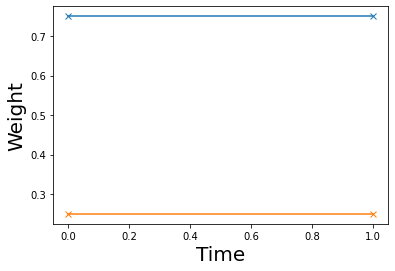

In [11]:
import matplotlib.pyplot as plt

ts = [t for t in range(0,L[0])]

for i in range(L[1]):
    plt.plot(ts,fvm[i,:],'-x')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Weight', fontsize=20)

Text(0, 0.5, 'Relative Profit')

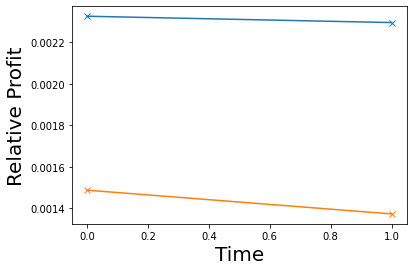

In [12]:
for i in range(L[1]):
    plt.plot(ts,mut[:,i],'-x')
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Relative Profit', fontsize=20)

# QAOA

In [25]:
#Must convert all parameters to pauli basis

Snew = {}
Inew = {}
for pair in S:
    Snew[pair[0]] = -S[pair]/2 if not pair[0] in Snew else Snew[pair[0]] - S[pair]/2
    Inew[pair[0]] = S[pair]/2 if not pair[0] in Inew else Inew[pair[0]] + S[pair]/2
    
for pair in D:
    if(pair[0]==pair[1]): #n^2 term
        Snew[pair[0]] = -D[pair]/2 if not pair[0] in Snew else Snew[pair[0]] -D[pair]/2
        Inew[pair[0]] = D[pair]/4 if not pair[0] in Inew else Inew[pair[0]] + D[pair]/4
    else:
        Snew[pair[0]] = -D[pair]/2 if not pair[0] in Snew else Snew[pair[0]] -D[pair]/2
        Snew[pair[1]] = -D[pair]/2 if not pair[1] in Snew else Snew[pair[1]] -D[pair]/2

#Z*Z is I
S2new = {}
for pair in D:
    if(pair[0]==pair[1]): #n^2 term
        Inew[pair[0]] = -D[pair]/4 if not pair[0] in Inew else Inew[pair[0]] - D[pair]/4

Dnew = {}
I2new = {}
for pair in D:
    if(pair[0]!=pair[1]): #n_a n_b term
        Dnew[pair] = D[pair]/4 if not pair in Dnew else Dnew[pair[0]] + D[pair]/4
        I2new[pair] = D[pair]/4 if not pair in I2new else I2new[pair[0]] + D[pair]/4    
        
        
print(S)
print(D)
print('\n')
print(Snew)
print(S2new)
print(Dnew)
print(Inew)
print(I2new)


{(0, 0): -2.5005812564998986, (1, 1): -5.001162512999797, (2, 2): -2.500371854002614, (3, 3): -5.000743708005228, (4, 4): -2.5005736479337526, (5, 5): -5.001147295867505, (6, 6): -2.50034328290288, (7, 7): -5.00068656580576}
{(0, 0): 0.3125, (0, 1): 1.25, (0, 3): 2.5, (0, 2): 0.625, (1, 1): 1.25, (1, 3): 2.5, (2, 2): 0.3125, (2, 3): 1.25, (3, 3): 1.25, (4, 4): 0.3125, (4, 5): 1.25, (4, 7): 2.5, (4, 6): 0.625, (5, 5): 1.25, (5, 7): 2.5, (6, 6): 0.3125, (6, 7): 1.25, (7, 7): 1.25}


{0: -1.0934593717500507, 1: 0.000581256499898597, 2: 0.15643592700130693, 3: -1.2496281459973861, 4: -1.0934631760331237, 5: 0.0005736479337525857, 6: 0.1564216414514401, 7: -1.2496567170971198}
{0: -0.078125, 1: -0.3125, 2: -0.078125, 3: -0.3125, 4: -0.078125, 5: -0.3125, 6: -0.078125, 7: -0.3125}
{(0, 1): 0.3125, (0, 3): 0.625, (0, 2): 0.15625, (1, 3): 0.625, (2, 3): 0.3125, (4, 5): 0.3125, (4, 7): 0.625, (4, 6): 0.15625, (5, 7): 0.625, (6, 7): 0.3125}
{0: -1.1721656282499493, 1: -2.1880812564998986, 2: -1.

In [28]:
n_wires = int(np.prod(L))

H = qml.Hamiltonian(
    [Snew[wire] for wire in Snew] + [Inew[wire] for wire in Inew] + [Dnew[wire] for wire in Dnew] + 
    [I2new[wire] for wire in I2new],
    [qml.PauliZ(wire) for wire in Snew] + [qml.Identity(wire) for wire in Inew] + [qml.PauliZ(wire[0])@qml.PauliZ(wire[1]) for wire in Dnew]
    + [qml.Identity(wire[0]) @ qml.Identity(wire[1]) for wire in I2new]    
)

print(H)    

  (-2.1880812564998986) [I1]
+ (-2.1880736479337526) [I5]
+ (-2.187871854002614) [I3]
+ (-2.18784328290288) [I7]
+ (-1.2496567170971198) [Z7]
+ (-1.2496281459973861) [Z3]
+ (-1.1721656282499493) [I0]
+ (-1.1721618239668763) [I4]
+ (-1.172060927001307) [I2]
+ (-1.17204664145144) [I6]
+ (-1.0934631760331237) [Z4]
+ (-1.0934593717500507) [Z0]
+ (0.0005736479337525857) [Z5]
+ (0.000581256499898597) [Z1]
+ (0.1564216414514401) [Z6]
+ (0.15643592700130693) [Z2]
+ (0.15625) [Z0 Z2]
+ (0.15625) [Z4 Z6]
+ (0.15625) [I0 I2]
+ (0.15625) [I4 I6]
+ (0.3125) [Z0 Z1]
+ (0.3125) [Z2 Z3]
+ (0.3125) [Z4 Z5]
+ (0.3125) [Z6 Z7]
+ (0.3125) [I0 I1]
+ (0.3125) [I2 I3]
+ (0.3125) [I4 I5]
+ (0.3125) [I6 I7]
+ (0.625) [Z0 Z3]
+ (0.625) [Z1 Z3]
+ (0.625) [Z4 Z7]
+ (0.625) [Z5 Z7]
+ (0.625) [I0 I3]
+ (0.625) [I1 I3]
+ (0.625) [I4 I7]
+ (0.625) [I5 I7]


In [29]:
Hm = qml.Hamiltonian(
    [1.0 for wire in range(n_wires)],
    [qml.PauliX(wire) for wire in range(n_wires)]
)

print(Hm)

  (1.0) [X0]
+ (1.0) [X1]
+ (1.0) [X2]
+ (1.0) [X3]
+ (1.0) [X4]
+ (1.0) [X5]
+ (1.0) [X6]
+ (1.0) [X7]


In [30]:
from pennylane import qaoa

In [31]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H)
    qaoa.mixer_layer(alpha, Hm)

In [32]:
depth = 2
wires = range(n_wires)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [33]:
dev = qml.device("qulacs.simulator", wires=wires)
cost_function = qml.ExpvalCost(circuit, H, dev)

In [34]:
optimizer = qml.GradientDescentOptimizer()
steps = 200
params = [[0.5,0.5], [0.5,0.5]]

In [35]:
for i in range(steps):
    params  = optimizer.step(cost_function, params)
    if (i+1)%5 == 0:
        print('Step {:5d}: {: .7f}'.format(i+1, cost_function(params)))

print("Optimal Parameters")
print(params)

Step     5: -9.9413807
Step    10: -10.2282798
Step    15: -10.3233617
Step    20: -10.3693503
Step    25: -10.3976074
Step    30: -10.4198959
Step    35: -10.4409054
Step    40: -10.4625755
Step    45: -10.4858007
Step    50: -10.5111092
Step    55: -10.5389446
Step    60: -10.5698052
Step    65: -10.6043529
Step    70: -10.6435564
Step    75: -10.6889436
Step    80: -10.7431061
Step    85: -10.8107965
Step    90: -10.9015060
Step    95: -11.0358843
Step   100: -11.2613395
Step   105: -11.6741014
Step   110: -12.3075816
Step   115: -12.7664654
Step   120: -12.8946171
Step   125: -12.9193541
Step   130: -12.9248335
Step   135: -12.9263857
Step   140: -12.9269096
Step   145: -12.9271028
Step   150: -12.9271770
Step   155: -12.9272060
Step   160: -12.9272174
Step   165: -12.9272219
Step   170: -12.9272238
Step   175: -12.9272245
Step   180: -12.9272248
Step   185: -12.9272249
Step   190: -12.9272249
Step   195: -12.9272249
Step   200: -12.9272249
Optimal Parameters
[[0.4965024987849432, 

In [36]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma,alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.bar(range(2**len(wires)), probs)
plt.show()

NameError: name 'wires' is not defined

In [38]:
print(np.argmax(probs))

102


In [44]:
for i in range(steps):
    params  = optimizer.step(cost_function, params)
    if (i+1)%5 == 0:
        print('Step {:5d}: {: .7f}'.format(i+1, cost_function(params)))

print("Optimal Parameters")
print(params)

Step     5: -12.9272249
Step    10: -12.9272249
Step    15: -12.9272249
Step    20: -12.9272250
Step    25: -12.9272250
Step    30: -12.9272250
Step    35: -12.9272250
Step    40: -12.9272250
Step    45: -12.9272250
Step    50: -12.9272250
Step    55: -12.9272250
Step    60: -12.9272250
Step    65: -12.9272250
Step    70: -12.9272250
Step    75: -12.9272250
Step    80: -12.9272250
Step    85: -12.9272250
Step    90: -12.9272250
Step    95: -12.9272250
Step   100: -12.9272250
Step   105: -12.9272250
Step   110: -12.9272250
Step   115: -12.9272250
Step   120: -12.9272250
Step   125: -12.9272250
Step   130: -12.9272250
Step   135: -12.9272250
Step   140: -12.9272250
Step   145: -12.9272250
Step   150: -12.9272250
Step   155: -12.9272250
Step   160: -12.9272250
Step   165: -12.9272250
Step   170: -12.9272250
Step   175: -12.9272250
Step   180: -12.9272250
Step   185: -12.9272250
Step   190: -12.9272250
Step   195: -12.9272250
Step   200: -12.9272250
Optimal Parameters
[[0.49649055067888065

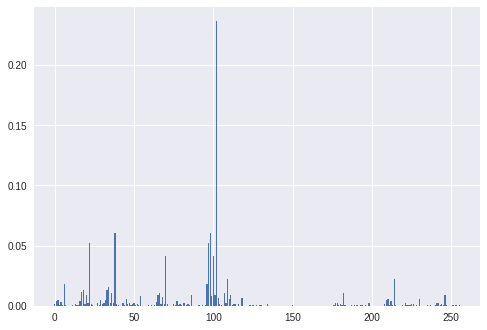

In [48]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.bar(range(2**len(wires)), probs)
plt.show()

In [52]:
#Most probabable State
sv = bin(np.argmax(probs))[2:].zfill(len(wires))
print(sv,max(probs))

01100110 0.23653221445966188


In [53]:
fvs = fnet.returnWeights(sv)
fvm = np.zeros([L[1],L[0]])

print(fvs)

for t in range(L[0]):
    for i in range(L[1]):        
        fvm[i,t] = fvs[t,i]
        if(abs(fvs[t,i]>1.0e-8)):
            print(t,i, fvs[t,i], mu(t,i))

[[0.5  0.25]
 [0.5  0.25]]
0 0 0.5 0.0023250259995950874
0 1 0.25 0.0014874160104551906
1 0 0.5 0.0022945917350109314
1 1 0.25 0.001373131611521413


Text(0, 0.5, 'Weight')

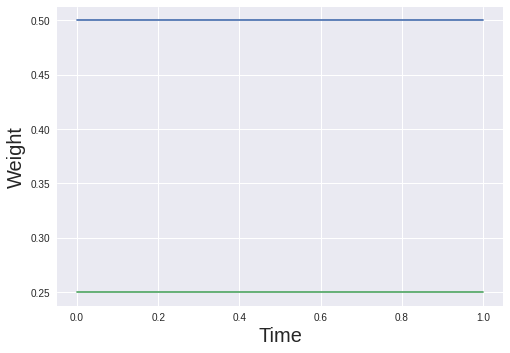

In [54]:
import matplotlib.pyplot as plt

ts = [t for t in range(0,L[0])]

for i in range(L[1]):
    plt.plot(ts,fvm[i,:],'-x')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Weight', fontsize=20)

Text(0, 0.5, 'Relative Profit')

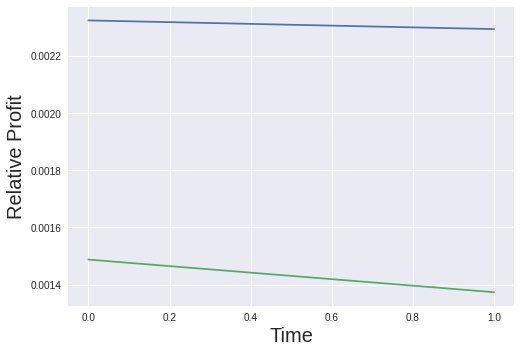

In [55]:
for i in range(L[1]):
    plt.plot(ts,mut[:,i],'-x')
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Relative Profit', fontsize=20)